In this notebook, we explore the implementation of image recognition task for the MNIST dataset using SIFT & SURF feature descriptors. The MNIST dataset, consisting of handwritten digit images, serves as a foundational benchmark for many computer vision tasks.

We'll leverage the power of classical ML models like SVDD and SVM, as well as deep learning models like CNNs to achieve accurate digit recognition.

## 1. Load the libraries and dataset

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset: MNIST
Shape of X: (60000, 28, 28)
Shape of y: (60000,)
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
--------------------------------------------------
--------------Training Data--------------


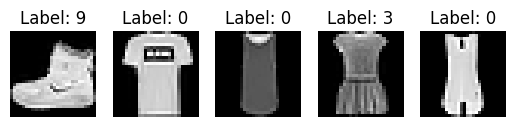

--------------Testing Data--------------


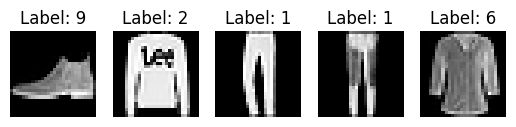

In [21]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Dataset Summary
def dataset_info(X, y, dataset_name):
    print(f"Dataset: {dataset_name}")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    print(f"Number of classes: {len(np.unique(y))}")
    print(f"Classes: {np.unique(y)}")
    print("-" * 50)

dataset_info(x_train, y_train, "MNIST")

# Display a few images from the training set
print("--------------Training Data--------------")
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()
# Display a few images from the testing set
print("--------------Testing Data--------------")
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

plt.show()

In [22]:
from skimage.color import rgb2gray
import cv2

def get_features(input_dataset, method, sigma=None):
    """
    Extract features from a set of images using SIFT or SURF.

    Parameters:
        input_datastore (list): List of file paths to the images.
        method (str): Feature extraction method ('SIFT' or 'SURF').
        sigma (float, optional): Sigma value for SIFT feature detection.

    Returns:
        features_out (np.ndarray): Feature scales (columns 1–5) and metrics (columns 6–10).
    """
    size_ds = len(input_dataset)
    features_out = np.zeros((size_ds, 10))

    for i, img in enumerate(input_dataset):
        # image agumentation for better keypoint detection
        # enhance contrast
        img_enhanced = cv2.equalizeHist(img)

        # # random noise
        # img_noisy = random_noise(img_enhanced, mode='gaussian', var=0.01)
        # img_noisy = (img_noisy * 255).astype(np.uint8)

        # Read and convert image to grayscale
        # img_gray = rgb2gray(img_enhanced) if len(img_enhanced.shape) == 3 else img_enhanced

        # Initialize feature detector
        if method == 'SIFT':
            sift = cv2.SIFT_create(contrastThreshold=sigma if sigma else 0.001)
            keypoints, _ = sift.detectAndCompute((img_enhanced * 255).astype('uint8'), None)
        elif method == 'ORB':
            orb = cv2.ORB_create()
            keypoints, _ = orb.detectAndCompute((img_enhanced * 255).astype('uint8'), None)
        else:
            raise ValueError(f"Unknown method: {method}")

        # Select strongest 5 keypoints
        if len(keypoints) > 0:
            keypoints = sorted(keypoints, key=lambda k: k.response, reverse=True)
            strongest_keypoints = keypoints[:5]
            scales = [kp.size for kp in strongest_keypoints]
            metrics = [kp.response for kp in strongest_keypoints]
        else:
            strongest_keypoints = []
            scales = []
            metrics = []
            print("Warning - not enough feature points!")

        # Fill features_out2 matrix
        diff = 5 - len(strongest_keypoints)
        features_out[i, :5] = scales + [0] * diff
        features_out[i, 5:] = metrics + [0] * diff

    return features_out

get_features(x_train, 'ORB')

流式输出内容被截断，只能显示最后 5000 行内容。
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - not enough feature points!
Warning - n

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
import cv2
import numpy as np
from skimage.color import rgb2gray

def get_features(input_dataset, method, sigma=None):
    """
    Extract features from a set of images using SIFT or ORB.

    Parameters:
        input_dataset (list): List of numpy arrays representing images.
        method (str): Feature extraction method ('SIFT' or 'ORB').
        sigma (float, optional): Sigma value for SIFT feature detection.

    Returns:
        features_out (np.ndarray): Feature scales (columns 1–5) and metrics (columns 6–10).
    """
    size_ds = len(input_dataset)
    features_out = np.zeros((size_ds, 10))

    for i, img in enumerate(input_dataset):
        # Validate input image
        if not isinstance(img, np.ndarray):
            raise ValueError(f"Image at index {i} is not a numpy array.")

        # Convert to grayscale if needed
        img_gray = rgb2gray(img) if len(img.shape) == 3 else img
        img_enhanced = cv2.equalizeHist((img_gray * 255).astype(np.uint8))

        # Initialize feature detector
        if method == 'SIFT':
            sift = cv2.SIFT_create(contrastThreshold=sigma if sigma else 0.0000000000000001)
            keypoints, _ = sift.detectAndCompute(img_enhanced, None)
        elif method == 'ORB':
            orb = cv2.ORB_create()
            keypoints, _ = orb.detectAndCompute(img_enhanced, None)
        else:
            raise ValueError(f"Unknown method: {method}")

        # Select strongest 5 keypoints
        if keypoints:
            keypoints = sorted(keypoints, key=lambda k: k.response, reverse=True)
            strongest_keypoints = keypoints[:5]
            scales = [kp.size for kp in strongest_keypoints]
            metrics = [kp.response for kp in strongest_keypoints]
        else:
            strongest_keypoints = []
            scales = []
            metrics = []
            print(f"Warning - not enough feature points in image {i + 1}!")

        # Fill features_out matrix
        diff = 5 - len(strongest_keypoints)
        features_out[i, :5] = scales + [0] * diff
        features_out[i, 5:] = metrics + [0] * diff

    return features_out

get_features(x_train, 'SIFT')

Warning - not enough feature points in image 31!
Warning - not enough feature points in image 48!
Warning - not enough feature points in image 64!
Warning - not enough feature points in image 74!
Warning - not enough feature points in image 88!
Warning - not enough feature points in image 106!
Warning - not enough feature points in image 210!
Warning - not enough feature points in image 276!
Warning - not enough feature points in image 286!
Warning - not enough feature points in image 309!
Warning - not enough feature points in image 379!
Warning - not enough feature points in image 380!
Warning - not enough feature points in image 415!
Warning - not enough feature points in image 428!
Warning - not enough feature points in image 509!
Warning - not enough feature points in image 524!
Warning - not enough feature points in image 548!
Warning - not enough feature points in image 569!
Warning - not enough feature points in image 586!
Warning - not enough feature points in image 589!
Warni

array([[3.29389191, 2.17230248, 2.17230248, ..., 0.0667945 , 0.06463294,
        0.05674836],
       [1.80336285, 4.0948782 , 3.94728899, ..., 0.04101809, 0.03981479,
        0.03883745],
       [6.368577  , 6.368577  , 2.92670417, ..., 0.04341735, 0.03159955,
        0.        ],
       ...,
       [1.99272001, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [5.39189291, 5.027987  , 5.027987  , ..., 0.06547911, 0.04066434,
        0.        ],
       [2.94741082, 1.99955642, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
import tensorflow_datasets as tfds


dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

# Display the basic information about the dataset
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.G3TZTV_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmp9fcpd88qtfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
  